In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import quantstats as qs

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.utils import plot_model

#sys.path.append('../')
from utils import *
from montecarlo import Montecarlo

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

# Load data

In [2]:
prices = pd.read_csv("data/SX5E/close_mat.csv")
composition = pd.read_csv("data/SX5E/SX5E Index_compositionMat.csv")
capitalization = pd.read_csv("data/SX5E/capitalization_mat.csv")

dataframes = {"prices": prices,
              "composition": composition,
              "capitalization": capitalization}

# 4 year training, 1 year testing
train_days = get_trading_dates(start_period="2013-01-01", end_period="2016-12-31", market="EUREX")
test_days = get_trading_dates(start_period="2017-01-01", end_period="2017-12-31", market="EUREX")

# print("Total number of training days:", len(train_days))
# print("First train day:", train_days[0])
# print("Last train day:", train_days[-1])

# print("\nTotal number of test days:", len(test_days))
# print("First test day:", test_days[0])
# print("Last test day:", test_days[-1])

# Set up and select time slice
for k, v in dataframes.items():
    d = setup_tables(v)
    d_train, d_test = d.loc[train_days], d.loc[test_days]
    dataframes[k] = (d_train, d_test)

stocks = get_full_time_stock_in_period(dataframes["composition"][0])
print("\nNumber of stocks fully present in training period:", len(stocks))

for k, v in dataframes.items():
    dataframes[k] = (v[0][stocks], v[1][stocks])

prices_train, prices_test = dataframes["prices"]
composition_train, composition_test = dataframes["composition"]
capitalization_train, capitalization_test = dataframes["capitalization"]

prices = pd.concat(dataframes["prices"])
composition = pd.concat(dataframes["composition"])
capitalization = pd.concat(dataframes["capitalization"])


Number of stocks fully present in training period: 41


# Parameters

In [12]:
TUKEY_C: float = 9.0
TUKEY_WINDOW: int = 4
LOOK_BACK: int = 252
FORECAST_HORIZON: int = 1
N_STOCKS: int = prices_train.shape[1]
N_SIMULATIONS: int = 20
TRAIN_EPOCHS: int = 20
BATCH_SIZE: int = 32
PORTFOLIOS: list[int] = [5, 7, 10]

## Apply Tukey location estimator on prices

In [13]:
tukey = apply_tukey(prices, c=TUKEY_C, window=TUKEY_WINDOW)

display(tukey.head())

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163


In [14]:
tukey_test = tukey.loc[test_days]
tukey_train = tukey.loc[train_days][TUKEY_WINDOW-1:]
print("Total number of training days:", len(tukey_train))
print("First train day:", tukey_train.index[0])
print("Last train day:", tukey_train.index[-1])

print("\nTotal number of test days:", len(tukey_test))
print("First test day:", tukey_test.index[0])
print("Last test day:", tukey_test.index[-1])

Total number of training days: 1015
First train day: 2013-01-07 00:00:00
Last train day: 2016-12-30 00:00:00

Total number of test days: 254
First test day: 2017-01-02 00:00:00
Last test day: 2017-12-29 00:00:00


# Montecarlo

In [15]:
def create_model(look_back: int = LOOK_BACK, n_stocks: int = N_STOCKS) -> Sequential:
    model = Sequential(name='CNN-LSTM')
    
    model.add(Conv1D(filters=n_stocks, kernel_size=3, activation='relu', input_shape=(look_back, N_STOCKS)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=n_stocks, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=n_stocks, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=n_stocks, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(RepeatVector(FORECAST_HORIZON))
    
    model.add(LSTM(100, activation='relu', return_sequences=True))
    
    model.add(TimeDistributed(Dense(100, activation='relu')))
    
    model.add(TimeDistributed(Dense(n_stocks)))
    
    model.compile(loss='mse', optimizer='adam')

    return model

In [16]:
scaler = MinMaxScaler()
montecarlo = Montecarlo(tukey_train, tukey_test, portfolios=[5, 7, 10], scaler=scaler, prices=True, log=False)

In [17]:
print(montecarlo.get_info())

n_sim: 100
n_epochs: 20
forecast_horizon: 1
look_back: 252
batch_size: 32
log: False
data_are_scaled: False


In [18]:
montecarlo.scale_data()

Scaling data with <class 'sklearn.preprocessing._data.MinMaxScaler'>


In [19]:
print(montecarlo.get_info())

n_sim: 100
n_epochs: 20
forecast_horizon: 1
look_back: 252
batch_size: 32
log: False
data_are_scaled: True


In [20]:
montecarlo.fit(create_model, N_SIMULATIONS, TRAIN_EPOCHS, FORECAST_HORIZON, LOOK_BACK, BATCH_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:06<00:00, 69.32s/it]


In [21]:
montecarlo.get_info()

'n_sim: 20\nn_epochs: 20\nforecast_horizon: 1\nlook_back: 252\nbatch_size: 32\nlog: False\ndata_are_scaled: True'

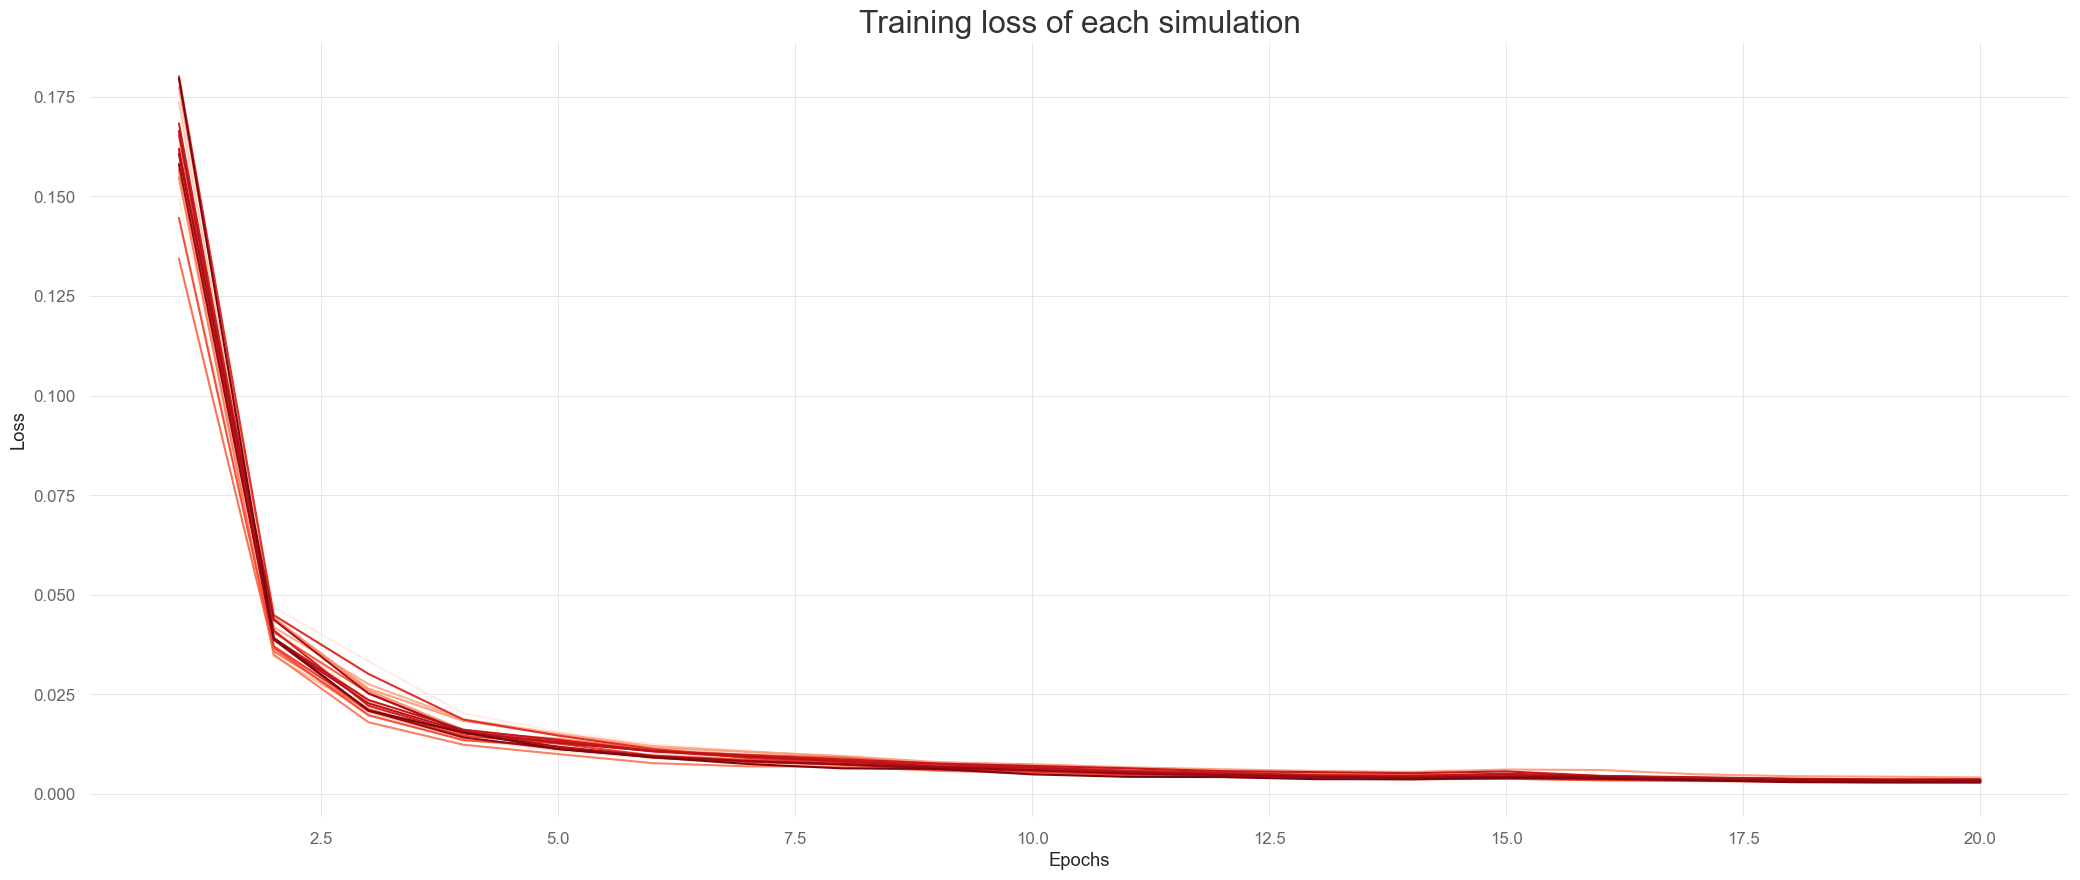

In [22]:
# Plot loss

sns.set_palette(sns.color_palette("Reds", N_SIMULATIONS, as_cmap=False))
fig, ax = plt.subplots(figsize=(21, 9), tight_layout=True)

for loss_series in montecarlo.loss_dict.values():
    ax.plot(np.arange(1, TRAIN_EPOCHS+1), loss_series)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training loss of each simulation", fontsize="xx-large")
plt.plot();

In [23]:
montecarlo.get_stocks_df()
montecarlo.get_portfolios_compositions()

{'Top 1': ['BAYN GY Equity'],
 'Top 2': ['ENGI FP Equity', 'EOAN GY Equity'],
 'Top 3': ['ENGI FP Equity', 'EOAN GY Equity', 'ABI BB Equity'],
 'Top 4': ['ENGI FP Equity',
  'EOAN GY Equity',
  'ABI BB Equity',
  'TEF SQ Equity'],
 'Top 5': ['ENGI FP Equity',
  'EOAN GY Equity',
  'TEF SQ Equity',
  'ABI BB Equity',
  'BN FP Equity'],
 'Top 6': ['ENGI FP Equity',
  'EOAN GY Equity',
  'TEF SQ Equity',
  'ABI BB Equity',
  'BN FP Equity',
  'EL FP Equity'],
 'Top 7': ['ENGI FP Equity',
  'ABI BB Equity',
  'EOAN GY Equity',
  'BN FP Equity',
  'TEF SQ Equity',
  'EL FP Equity',
  'DG FP Equity'],
 'Top 8': ['ENGI FP Equity',
  'BN FP Equity',
  'ABI BB Equity',
  'EOAN GY Equity',
  'TEF SQ Equity',
  'EL FP Equity',
  'null.2',
  'VIV FP Equity'],
 'Top 9': ['ENGI FP Equity',
  'ABI BB Equity',
  'BN FP Equity',
  'TEF SQ Equity',
  'EL FP Equity',
  'EOAN GY Equity',
  'null.2',
  'VIV FP Equity',
  'ORA FP Equity'],
 'Top 10': ['ENGI FP Equity',
  'ABI BB Equity',
  'TEF SQ Equity',


In [24]:
util_df_prices = pd.concat([prices_train[-1:], prices_test])
test_returns = price_to_returns(util_df_prices, log=False, drop_na=False)[1:]
perf_dict_forecast, ret_dict_forecast = calc_portfolios(assets=montecarlo.portfolios_composition, test_ret=test_returns, log=False)

real_top_portfolios = get_ranking(util_df_prices, N=list(range(1, 11)), prices=True, log=False)
perf_dict_real, ret_dict_real = calc_portfolios(assets=real_top_portfolios, test_ret=test_returns, log=False)

In [25]:
perf_dict_forecast

{'Top 1': 4.912739683249012,
 'Top 2': 26.757193436795788,
 'Top 3': 15.378322701229408,
 'Top 4': 9.563788174245458,
 'Top 5': 10.890231888810732,
 'Top 6': 10.255134023496293,
 'Top 7': 13.305461651894767,
 'Top 8': 13.331803244262774,
 'Top 9': 11.88128110469535,
 'Top 10': 10.03645593453264}

In [26]:
perf_dict_real

{'Top 1': 36.099382859608475,
 'Top 2': 35.69026534198465,
 'Top 3': 35.539779522755175,
 'Top 4': 34.5566914976378,
 'Top 5': 32.6097321629943,
 'Top 6': 31.204129706051596,
 'Top 7': 29.959658818811707,
 'Top 8': 28.961516753084425,
 'Top 9': 28.07107093516241,
 'Top 10': 27.091521740575697}

In [27]:
# Benchmark
ew_benchmark = pd.concat([prices_train[-1:], prices_test])
ew_benchmark = price_to_cumulative_returns(ew_benchmark)
ew_benchmark = ew_benchmark / len(ew_benchmark.columns)
ew_benchmark = ew_benchmark.sum(axis=1)
ew_benchmark.rename("Equal weight benchmark strategy", inplace=True);

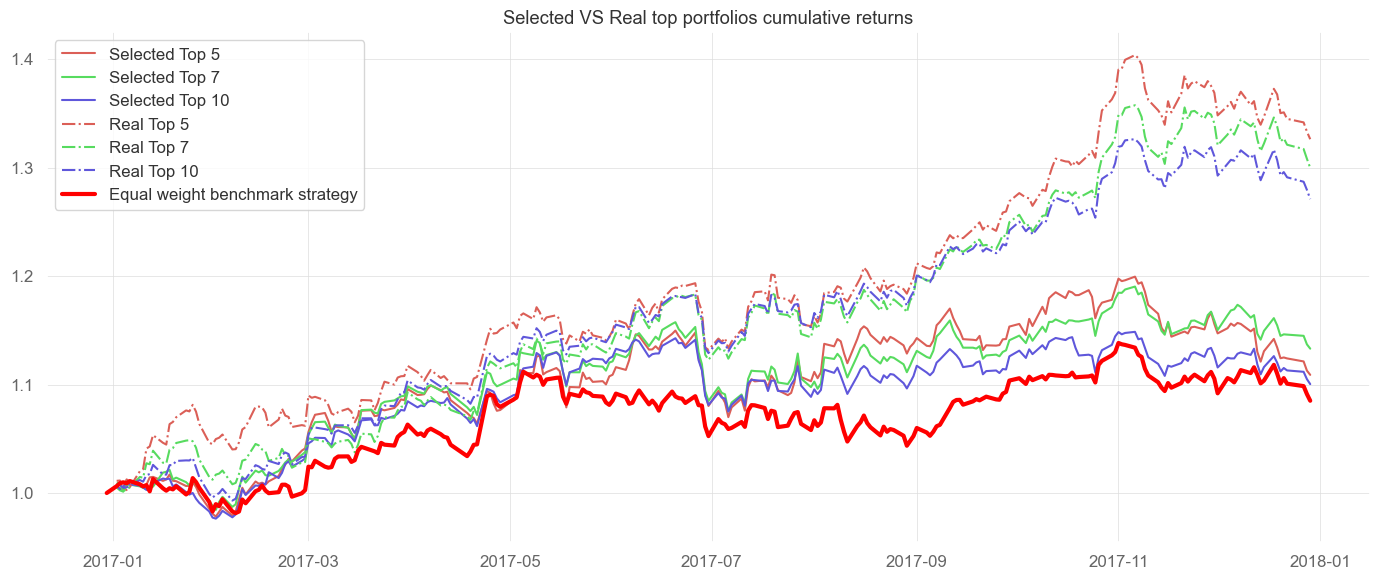

In [28]:
palette = sns.color_palette("hls", len(PORTFOLIOS))
fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)

for i, color in zip(PORTFOLIOS, palette):
    s = ret_dict_forecast[f"Top {i}"]
    l = cumulative_returns_from_series(s, log=False)
    ax.plot(l, label=f"Selected Top {i}", color=color)
    #ax.text(l.index[-1], l.iloc[-1], f"  {l.iloc[-1]:.3f}", color=color, horizontalalignment="left")

for i, color in zip(PORTFOLIOS, palette):
    s = ret_dict_real[f"Top {i}"]
    l = cumulative_returns_from_series(s, log=False)
    ax.plot(l, label=f"Real Top {i}", color=color, linestyle="-.")
    #ax.text(l.index[-1], l.iloc[-1], f"  {l.iloc[-1]:.3f}", color=color, horizontalalignment="left")

ax.plot(ew_benchmark, label=ew_benchmark.name, color="red", linewidth=3)

ax.legend()
ax.set_title("Selected VS Real top portfolios cumulative returns")
plt.plot();